In [49]:
import os
import numpy as np
import time 
from collections import defaultdict
import numpy.ma as ma
from scipy.optimize import linear_sum_assignment
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch_geometric.data import Data, DataLoader  # PyG Data and loader
from torch.optim import Adam, SGD
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define the transform to downsample the images to 14x14 pixels
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((14, 14)),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the MNIST dataset with the downsampling transform
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# # Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# test_features, test_labels = next(iter(test_loader))
# true = test_features[0].squeeze()
# plt.imshow(true, cmap="gray")
# print(f"Downsampled MNIST tensor shape: {true.shape}")

# Define MNIST classifier MLP class for dataset
class MLP(nn.Module):
    def __init__(self, init_type='xavier', seed=None):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(196, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
        if seed is not None:
            torch.manual_seed(seed)  # Set a unique seed for reproducibility

        self.init_weights(init_type)

    def init_weights(self, init_type):
        if init_type == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_type == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.normal_(self.fc1.weight)
            nn.init.normal_(self.fc2.weight)
            nn.init.normal_(self.fc3.weight)
        
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)

    def forward(self, x):
        x = x.view(-1, 196)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
def test_mlp(model, test_loader, device = device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No need to compute gradients for evaluation
        for data, target in test_loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

def train_mlp(model, epochs=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    model.train()
    for epoch in range(epochs):
        for data, target in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

# Functions for permutations and weight matching
def permute_layer_weights(layer, perm):
    """Permutes weights and biases of a layer based on the given permutation matrix."""
    weight = layer.weight.data.clone()
    bias = layer.bias.data.clone()

    # Permute rows of weights (output dimension)
    layer.weight.data = weight[perm, :]

    # Permute bias (output dimension)
    layer.bias.data = bias[perm]
    return layer

def permute_model(model, permutations):
    """Applies a list of permutations to a model's layers."""
    permute_layer_weights(model.fc1, permutations[0])
    permute_layer_weights(model.fc2, permutations[1])

    # Adjust input weights of the second hidden layer
    model.fc2.weight.data = model.fc2.weight.data[:, permutations[0]]
    # Adjust input weights of the output layer
    model.fc3.weight.data = model.fc3.weight.data[:, permutations[1]]
    return model

# Functions to permute weights and adjust input weights
def apply_permutation(layer, perm):
    """
    Applies the given permutation to the weights and biases of a layer.
    Args:
        layer: The layer to permute.
        perm: The permutation array.
    """
    # Permute rows (output dimension) of weights
    layer.weight.data = layer.weight.data[perm, :]
    # Permute biases
    layer.bias.data = layer.bias.data[perm]

def adjust_input_weights(layer, perm):
    """
    Adjusts the input wei
    ghts of a layer according to the permutation of the previous layer.
    Args:
        layer: The layer to adjust.
        perm: The permutation array of the previous layer.
    """
    layer.weight.data = layer.weight.data[:, perm]
    
def generate_permutation_matrix(hidden_dim):
    """Generates a random permutation matrix."""
    perm = np.random.permutation(hidden_dim)
    return torch.tensor(perm, dtype=torch.long)

def compute_similarity_matrix(weights_a, weights_b):
    """
    Computes the similarity matrix for two layers' weights.
    """
    weights_a = weights_a.view(weights_a.size(0), -1)
    weights_b = weights_b.view(weights_b.size(0), -1)
    return torch.matmul(weights_a, weights_b.T)

def get_permuted_weights(weights, perm):
    """
    Permutes the rows of weights based on the given permutation.
    """
    return weights[perm, :]


def weight_matching(rng, model_a, model_b, max_iter=100, init_perm=None):
    """
    Optimizes permutations to match Model B to Model A.
    """
    layers = ['fc1', 'fc2', 'fc3']
    perm_sizes = {layer: getattr(model_a, layer).weight.size(0) for layer in layers[:-1]}
    perm = {layer: np.arange(size) for layer, size in perm_sizes.items()} if init_perm is None else init_perm

    for iteration in range(max_iter):
        progress = False
        for layer in layers[:-1]:  # Exclude the output layer (fc3)
            n = perm_sizes[layer]
            similarity_matrix = compute_similarity_matrix(
                getattr(model_a, layer).weight.data,
                get_permuted_weights(getattr(model_b, layer).weight.data, perm[layer])
            )
            row_ind, col_ind = linear_sum_assignment(similarity_matrix.numpy(), maximize=True)

            old_score = np.sum(similarity_matrix.numpy()[np.arange(n), perm[layer]])
            new_score = np.sum(similarity_matrix.numpy()[np.arange(n), col_ind])

            if new_score > old_score:
                perm[layer] = col_ind
                progress = True

        if not progress:
            break

    return perm, new_score

def rebase_model_b_to_a(rng, model_a, model_b, max_iter=100):
    """
    Rebases Model B to match Model A using weight matching.
    """
    # Generate initial permutations
    init_perm = {layer: generate_permutation_matrix(getattr(model_a, layer).weight.size(0)) for layer in ['fc1', 'fc2']}
    
    # Perform weight matching
    permutations, score = weight_matching(rng, model_a, model_b, max_iter=max_iter, init_perm=init_perm)
    
    # Apply the permutations to Model B
    model_b = permute_model(model_b, [permutations['fc1'], permutations['fc2']])
    
    return model_b, permutations, score

def load_model_weights(model, weight_path):
    # Load weights and biases
    weights, biases = torch.load(weight_path)
    model.fc1.weight.data = weights[0]
    model.fc2.weight.data = weights[1]
    model.fc3.weight.data = weights[2]
    model.fc1.bias.data = biases[0]
    model.fc2.bias.data = biases[1]
    model.fc3.bias.data = biases[2]
    return model

def reconstruct_model(model, final_permutations):
    """
    Reconstruct model_b by applying the final permutations to its layers.
    Args:
        model_b (MLP): The model to be reconstructed.
        final_permutations (dict): Dictionary containing layer-wise permutations.
    Returns:
        MLP: The reconstructed model.
    """
    # Apply permutations to fc1 layer
    apply_permutation(model.fc1, final_permutations[1]['fc1'])
    adjust_input_weights(model.fc2, final_permutations[1]['fc1'])
    
    # Apply permutations to fc2 layer
    apply_permutation(model.fc2, final_permutations[1]['fc2'])
    adjust_input_weights(model.fc3, final_permutations[1]['fc2'])
    
    # Return the reconstructed model
    return model

def extract_weights_and_biases(model):
    """Flatten the weights and biases of each layer in the model into a single vector."""
    all_weights_biases = []
    
    # Flatten weights and biases for each layer
    for layer_name in ['fc1', 'fc2', 'fc3']:
        weights = getattr(model, layer_name).weight.data.numpy().flatten()  # Flatten the weights
        biases = getattr(model, layer_name).bias.data.numpy().flatten()    # Flatten the biases
        all_weights_biases.extend(weights)
        all_weights_biases.extend(biases)
    
    return np.array(all_weights_biases)

def get_permuted_models_data(ref_point=0, N = 10, path = f"models/MNIST_mixed_mlp_weights_{0}.pt"): # f"models/reduced_mlp_weights_{0}.pt"
    ref_model = MLP()
    ref_model_path = path #f"models/reduced_mlp_weights_{ref_point}.pt"
#     ref_model_path =   f"models/dropout_mlp_weights_{ref_point}.pt"

    ref_model = load_model_weights(ref_model, ref_model_path)
    
    org_models=[]
    permuted_models = []
    full_times = []
    rebasin_times = []
    scores = []
    rng = np.random.default_rng(42)

    for i in range(0,N):
        if i == ref_point:
            continue
        all_start = time.time() # start timing
        model_path = f"models/MNIST_mixed_mlp_weights_{i}.pt" #f"models/reduced_mlp_weights_{i}.pt"
#         model_path = f"models/dropout_mlp_weights_{i}.pt"
        
        model = MLP()
        model = load_model_weights(model, model_path)
        org_models.append(model)
        loaded_model = time.time() # end timing for loading the model from .pth file
        
        reconstructed_model, final_permutations, score = rebase_model_b_to_a(rng, ref_model, model, max_iter=100)
        scores.append(score)
        permuted_models.append(reconstructed_model)
        all_end = time.time() # end timing for the entire loop
        
        full_times.append(all_end - all_start)
        rebasin_times.append(all_end - loaded_model)
        
#         print(f"Org model accuracy:{test_mlp(model, test_loader)} Reconstructed model accuracy:{test_mlp(reconstructed_model, test_loader)}")
    return org_models, permuted_models, scores, rebasin_times

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv


def build_mlp(generated_data):
    """
    generated_data: a Data object that has the reconstructed node features (x)
    and edge attributes (edge_attr).  
    The original graph was built as:
      - First 196 nodes: input layer,
      - Next 32 nodes: fc1 neurons,
      - Next 32 nodes: fc2 neurons,
      - Next 10 nodes: fc3 neurons.
    Edge ordering is:
      - fc1: edges from input (196 nodes) to fc1 (32 nodes) in a nested loop:
             for i in range(32): for j in range(196)
      - fc2: edges from fc1 (32 nodes) to fc2 (32 nodes)
      - fc3: edges from fc2 (32 nodes) to fc3 (10 nodes)
    This function instantiates a new MLP and sets its weights and biases from the generated outputs.
    """
    x_rec = generated_data.x.squeeze()  # shape: (196+32+32+10,)
    edge_attr_rec = generated_data.edge_attr  # shape: (32*196 + 32*32 + 10*32,)

    # Extract biases.
    fc1_bias = x_rec[196:196+32]
    fc2_bias = x_rec[196+32:196+32+32]
    fc3_bias = x_rec[196+32+32:196+32+32+10]

    # Extract edge weights.
    # For fc1: first 32*196 values.
    fc1_weight = edge_attr_rec[:32*196].view(32, 196)
    # For fc2: next 32*32 values.
    start_fc2 = 32*196
    fc2_weight = edge_attr_rec[start_fc2:start_fc2+32*32].view(32, 32)
    # For fc3: remaining 10*32 values.
    start_fc3 = start_fc2 + 32*32
    fc3_weight = edge_attr_rec[start_fc3:start_fc3+10*32].view(10, 32)

    # Create a new instance of the MLP.
    new_mlp = MLP()
    # Assign weights and biases.
    with torch.no_grad():
        new_mlp.fc1.weight.copy_(fc1_weight)
        new_mlp.fc1.bias.copy_(fc1_bias)
        new_mlp.fc2.weight.copy_(fc2_weight)
        new_mlp.fc2.bias.copy_(fc2_bias)
        new_mlp.fc3.weight.copy_(fc3_weight)
        new_mlp.fc3.bias.copy_(fc3_bias)
    return new_mlp

from torch_geometric.nn import NNConv, GraphNorm, PNAConv

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import NNConv, GraphNorm
from torch_geometric.data import DataLoader

def count_parameters(model):
    """
    Function: Count the learnable params in a portion of the model
    Args: model segment (ie, encoder, decoder, entire model)
    Returns: the number of learnable params in that model/segment
    """
    total_params = sum(p.numel() for p in model.parameters())
    return total_params

import torch
from torch_geometric.data import Data

class MLPGraphDatasetNeuronsFromList(torch.utils.data.Dataset):
    def __init__(self, mlp_list):
        """
        mlp_list: a list of MLP objects.
        """
        self.models = mlp_list
        
    def __len__(self):
        return len(self.models)
        
    def __getitem__(self, idx):
        # Get the MLP instance from the list
        mlp = self.models[idx]
        
        # Extract weights and biases directly from the model's layers
        # We assume the model has attributes fc1, fc2, fc3
        weights = [mlp.fc1.weight, mlp.fc2.weight, mlp.fc3.weight]
        biases = [mlp.fc1.bias, mlp.fc2.bias, mlp.fc3.bias]
        
        # --- Build Node Features ---
        # Input layer: create nodes based on the input dimension of fc1
        input_dim = weights[0].shape[1]  # 196 for MNIST
        input_feats = torch.zeros(input_dim, 1)
        
        # For subsequent layers, use the bias of each layer as the node feature
        node_features = [input_feats]
        for b in biases:
            node_feats = b.view(-1, 1)
            node_features.append(node_feats)
        
        # Concatenate features from all layers
        # Total nodes = input_dim + sum(layer output sizes)
        x = torch.cat(node_features, dim=0)
        
        # --- Build Edges and Edge Attributes ---
        edge_index_list = []
        edge_attr_list = []
        
        # Keep track of node indices for each layer
        layer_starts = [0]  # input layer starts at 0
        current_offset = input_dim
        
        # Calculate starting indices for each hidden/output layer
        for b in biases:
            layer_starts.append(current_offset)
            current_offset += b.shape[0]
        
        # print(f"Layer starts: {layer_starts}")
        # print(f"Total nodes: {current_offset}")
        # print(f"Layer sizes: input={input_dim}, fc1={biases[0].shape[0]}, fc2={biases[1].shape[0]}, fc3={biases[2].shape[0]}")
        
        # Build edges for each layer
        for layer_idx, w in enumerate(weights):
            in_dim = w.shape[1]    # number of source nodes
            out_dim = w.shape[0]   # number of destination nodes
            
            src_start = layer_starts[layer_idx]      # start of source layer
            dst_start = layer_starts[layer_idx + 1]  # start of destination layer
            
            # print(f"Layer {layer_idx}: connecting {in_dim} nodes (start={src_start}) to {out_dim} nodes (start={dst_start})")
            
            # Create edges: for each output neuron, connect to all input neurons
            for i_out in range(out_dim):
                for j_in in range(in_dim):
                    src = src_start + j_in    # source node index
                    dst = dst_start + i_out   # destination node index
                    
                    edge_index_list.append([src, dst])
                    # PyTorch weight[i, j] is connection from input j to output i
                    edge_attr_list.append([w[i_out, j_in].item()])
        
        # Convert lists to torch tensors
        edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
        
        # print(f"Created graph with {x.shape[0]} nodes and {edge_index.shape[1]} edges")
        # print(f"Edge index shape: {edge_index.shape}")
        # print(f"Edge attr shape: {edge_attr.shape}")
        # print(f"Node features shape: {x.shape}")
        
        return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)


cpu


# Build dataset/loader:

In [53]:
org_models, permuted_models, scores, rebasin_times = get_permuted_models_data(ref_point=0, N = 180) 

dataset = MLPGraphDatasetNeuronsFromList(permuted_models)

loader = DataLoader(dataset, batch_size=16, shuffle=True)

/var/folders/js/697gbr4j3lzdh9ccy7qxb5ph0000gn/T/ipykernel_22155/26954655.py:219: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights, biases = torch.load(weight_path)


# MOE on edges 

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import PNAConv, BatchNorm, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.utils import degree
import math

class EdgeUpdateMLP(nn.Module):
    """Enhanced MLP for updating edge features with stronger capacity"""
    def __init__(self, node_dim, edge_dim, hidden_dim=128, num_layers=3):
        super().__init__()
        
        layers = []
        input_dim = 2 * node_dim + edge_dim
        
        for i in range(num_layers):
            if i == 0:
                layers.extend([
                    nn.Linear(input_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(0.1)
                ])
            elif i == num_layers - 1:
                layers.append(nn.Linear(hidden_dim, edge_dim))
            else:
                layers.extend([
                    nn.Linear(hidden_dim, hidden_dim),
                    nn.LayerNorm(hidden_dim),
                    nn.ReLU(),
                    nn.Dropout(0.1)
                ])
        
        self.edge_update = nn.Sequential(*layers)
        
    def forward(self, node_i, edge_features, node_j):
        edge_input = torch.cat([node_i, edge_features, node_j], dim=-1)
        return self.edge_update(edge_input)

class PNAWithStrongEdgeUpdates(nn.Module):
    """PNA layer with enhanced edge feature updates"""
    def __init__(self, node_in_dim, edge_in_dim, node_out_dim, edge_out_dim, 
                 aggregators=['mean', 'min', 'max', 'std'], scalers=['identity', 'amplification', 'attenuation'],
                 deg=None, towers=3, pre_layers=2, post_layers=2, edge_update_layers=3):
        super().__init__()
        
        # Ensure node_out_dim is divisible by towers
        if node_out_dim % towers != 0:
            node_out_dim = ((node_out_dim // towers) + 1) * towers
            print(f"Adjusted node_out_dim to {node_out_dim} to be divisible by {towers} towers")
        
        # Enhanced PNA for node updates
        self.pna_conv = PNAConv(
            in_channels=node_in_dim,
            out_channels=node_out_dim,
            aggregators=aggregators,
            scalers=scalers,
            deg=deg,
            towers=towers,
            pre_layers=pre_layers,
            post_layers=post_layers,
            divide_input=False,
            edge_dim=edge_in_dim
        )
        
        # Stronger edge update network
        self.edge_update = EdgeUpdateMLP(
            node_dim=node_in_dim,
            edge_dim=edge_in_dim,
            hidden_dim=max(128, edge_out_dim * 2),
            num_layers=edge_update_layers
        )
        
        # Edge projection with residual
        if edge_in_dim != edge_out_dim:
            self.edge_proj = nn.Linear(edge_in_dim, edge_out_dim)
        else:
            self.edge_proj = nn.Identity()
            
        self.node_norm = BatchNorm(node_out_dim)
        self.edge_norm = BatchNorm(edge_out_dim)
        
        # Edge attention mechanism
        self.edge_attention = nn.Sequential(
            nn.Linear(edge_out_dim, edge_out_dim // 4),
            nn.ReLU(),
            nn.Linear(edge_out_dim // 4, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x, edge_index, edge_attr):
        # Update nodes using PNA
        x_new = self.pna_conv(x, edge_index, edge_attr)
        x_new = self.node_norm(x_new)
        
        # Update edges with enhanced network
        row, col = edge_index
        edge_new = self.edge_update(x[row], edge_attr, x[col])
        
        # Residual connection for edges
        edge_new = edge_new + self.edge_proj(edge_attr)
        edge_new = self.edge_norm(edge_new)
        
        # Apply edge attention
        edge_attention_weights = self.edge_attention(edge_new)
        edge_new = edge_new * edge_attention_weights
        
        return F.relu(x_new), F.relu(edge_new)

class EdgeFocusedEncoder(nn.Module):
    """Encoder that prioritizes edge information"""
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, latent_dim, 
                 num_layers=4, deg=None):
        super().__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        
        # Enhanced input projections
        self.node_input_proj = nn.Sequential(
            nn.Linear(node_in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        
        self.edge_input_proj = nn.Sequential(
            nn.Linear(edge_in_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU()
        )
        
        # PNA layers with strong edge updates
        self.pna_layers = nn.ModuleList()
        for i in range(num_layers):
            layer = PNAWithStrongEdgeUpdates(
                node_in_dim=hidden_dim,
                edge_in_dim=hidden_dim,
                node_out_dim=hidden_dim,
                edge_out_dim=hidden_dim,
                deg=deg,
                towers=3,
                pre_layers=2,
                post_layers=2,
                edge_update_layers=3
            )
            self.pna_layers.append(layer)
            
        # Multi-level pooling for edge information
        self.edge_pooling = nn.ModuleList([
            nn.Linear(hidden_dim, latent_dim // 4),
            nn.Linear(hidden_dim, latent_dim // 4),
            nn.Linear(hidden_dim, latent_dim // 4)
        ])
        
        # Node to latent
        self.node_to_latent = nn.Linear(hidden_dim, latent_dim // 4)
        
        # Final latent projection
        self.final_proj = nn.Sequential(
            nn.Linear(latent_dim, latent_dim),
            nn.LayerNorm(latent_dim),
            nn.ReLU(),
            nn.Linear(latent_dim, latent_dim)
        )
        
    def forward(self, x, edge_index, edge_attr, batch=None):
        # Enhanced input projections
        x = self.node_input_proj(x)
        edge_attr = self.edge_input_proj(edge_attr)
        
        edge_representations = []
        
        # Apply PNA layers with edge collection
        for i, layer in enumerate(self.pna_layers):
            x_new, edge_attr_new = layer(x, edge_index, edge_attr)
            
            # Collect edge representations at different depths
            if i < 3:  # First 3 layers
                # Pool edge features per graph if batched
                if batch is not None:
                    # Create batch assignment for edges
                    row, col = edge_index
                    edge_batch = batch[row]  # Each edge belongs to the same graph as its source node
                    edge_pooled = global_mean_pool(edge_attr_new, edge_batch)
                else:
                    edge_pooled = global_mean_pool(edge_attr_new, torch.zeros(edge_attr_new.size(0), dtype=torch.long, device=edge_attr_new.device))
                
                edge_repr = self.edge_pooling[i](edge_pooled)
                edge_representations.append(edge_repr)
            
            # Residual connections
            x = x + x_new if x.size(-1) == x_new.size(-1) else x_new
            edge_attr = edge_attr + edge_attr_new if edge_attr.size(-1) == edge_attr_new.size(-1) else edge_attr_new
            
        # Node pooling per graph
        if batch is not None:
            node_pooled = global_mean_pool(x, batch)
        else:
            node_pooled = global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long, device=x.device))
        
        node_repr = self.node_to_latent(node_pooled)
        
        # Combine all representations
        combined = torch.cat(edge_representations + [node_repr], dim=-1)
        z = self.final_proj(combined)
        
        return z

class EdgeExpertDecoder(nn.Module):
    """Decoder specialized for accurate edge reconstruction"""
    def __init__(self, latent_dim, node_out_dim, edge_out_dim, hidden_dim=256, num_edge_experts=4):
        super().__init__()
        
        self.latent_dim = latent_dim
        self.node_out_dim = node_out_dim
        self.edge_out_dim = edge_out_dim
        self.num_edge_experts = num_edge_experts
        
        # Enhanced node reconstruction
        self.node_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, node_out_dim)
        )
        
        # Multiple edge expert networks
        self.edge_experts = nn.ModuleList()
        for _ in range(num_edge_experts):
            expert = nn.Sequential(
                nn.Linear(2 * latent_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.1),
                nn.Linear(hidden_dim, edge_out_dim)
            )
            self.edge_experts.append(expert)
        
        # Expert gating network
        self.expert_gate = nn.Sequential(
            nn.Linear(2 * latent_dim, hidden_dim // 4),
            nn.ReLU(),
            nn.Linear(hidden_dim // 4, num_edge_experts),
            nn.Softmax(dim=-1)
        )
        
        # Edge refinement network
        self.edge_refiner = nn.Sequential(
            nn.Linear(edge_out_dim + 2 * latent_dim, hidden_dim // 2),
            nn.LayerNorm(hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, edge_out_dim)
        )
        
    def forward(self, z, edge_index, batch=None):
        # z is graph-level latent [batch_graphs, latent_dim]
        # We need to expand it to node-level [num_nodes, latent_dim]
        
        if batch is None:
            # Single graph case
            num_nodes = edge_index.max().item() + 1
            z_expanded = z.expand(num_nodes, -1)  # [num_nodes, latent_dim]
        else:
            # Batched case: batch tells us which graph each node belongs to
            # z[i] should be broadcasted to all nodes in graph i
            num_nodes = batch.size(0)
            z_expanded = torch.zeros(num_nodes, z.size(-1), device=z.device)
            
            # For each unique graph in the batch
            unique_graphs = torch.unique(batch)
            for graph_idx in unique_graphs:
                node_mask = (batch == graph_idx)
                z_expanded[node_mask] = z[graph_idx]
        
        # Node reconstruction
        node_recon = self.node_decoder(z_expanded)
        
        # Edge reconstruction with mixture of experts
        row, col = edge_index
        edge_input = torch.cat([z_expanded[row], z_expanded[col]], dim=-1)
        
        # Get expert predictions
        expert_outputs = []
        for expert in self.edge_experts:
            expert_out = expert(edge_input)
            expert_outputs.append(expert_out)
        
        # Get gating weights
        gate_weights = self.expert_gate(edge_input)  # [num_edges, num_experts]
        
        # Combine expert outputs
        edge_pred = torch.zeros_like(expert_outputs[0])
        for i, expert_out in enumerate(expert_outputs):
            edge_pred += gate_weights[:, i:i+1] * expert_out
        
        # Refine edge predictions
        refine_input = torch.cat([edge_pred, edge_input], dim=-1)
        edge_pred = edge_pred + self.edge_refiner(refine_input)
        
        return node_recon, edge_pred

class EdgeFocusedAutoEncoder(nn.Module):
    """AutoEncoder specifically designed for accurate edge reconstruction"""
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, latent_dim, 
                 num_layers=4, deg=None, noise_std=0.05, edge_weight=10.0):
        super().__init__()
        
        self.encoder = EdgeFocusedEncoder(
            node_in_dim=node_in_dim,
            edge_in_dim=edge_in_dim,
            hidden_dim=hidden_dim,
            latent_dim=latent_dim,
            num_layers=num_layers,
            deg=deg
        )
        
        self.decoder = EdgeExpertDecoder(
            latent_dim=latent_dim,
            node_out_dim=node_in_dim,
            edge_out_dim=edge_in_dim,
            hidden_dim=hidden_dim,
            num_edge_experts=4
        )
        
        self.noise_std = noise_std
        self.edge_weight = edge_weight  # Higher weight for edge loss
        
    def forward(self, data):
        """Forward pass returns latent representation"""
        return self.encoder(data.x, data.edge_index, data.edge_attr, getattr(data, 'batch', None))
        
    def compute_loss(self, data):
        """Compute reconstruction loss with edge focus"""
        # Encode to latent space
        z = self.encoder(data.x, data.edge_index, data.edge_attr, getattr(data, 'batch', None))
        
        # Add noise to latent for robustness during training
        if self.training and self.noise_std > 0:
            z = z + torch.randn_like(z) * self.noise_std
            
        # Decode - ONLY using z and edge_index (no edge_attr!)
        node_recon, edge_recon = self.decoder(z, data.edge_index, 
                                            getattr(data, 'batch', None))
        
        # Compute reconstruction losses
        node_loss = F.mse_loss(node_recon, data.x)
        edge_loss = F.mse_loss(edge_recon, data.edge_attr)
        
        # Additional edge losses for better reconstruction
        edge_l1_loss = F.l1_loss(edge_recon, data.edge_attr)
        
        # Weighted combination with edge emphasis
        total_loss = node_loss + self.edge_weight * (edge_loss + 0.1 * edge_l1_loss)
        
        return total_loss, node_loss, edge_loss
    
    def compute_detailed_loss(self, data):
        """More detailed loss computation for analysis"""
        z = self.encoder(data.x, data.edge_index, data.edge_attr, getattr(data, 'batch', None))
        
        if self.training and self.noise_std > 0:
            z = z + torch.randn_like(z) * self.noise_std
            
        node_recon, edge_recon = self.decoder(z, data.edge_index, 
                                            getattr(data, 'batch', None))
        
        # Multiple loss metrics
        node_mse = F.mse_loss(node_recon, data.x)
        edge_mse = F.mse_loss(edge_recon, data.edge_attr)
        edge_l1 = F.l1_loss(edge_recon, data.edge_attr)
        
        # Edge magnitude preservation
        edge_mag_orig = torch.norm(data.edge_attr, dim=1)
        edge_mag_recon = torch.norm(edge_recon, dim=1)
        edge_mag_loss = F.mse_loss(edge_mag_recon, edge_mag_orig)
        
        total_loss = node_mse + self.edge_weight * (edge_mse + 0.1 * edge_l1 + 0.1 * edge_mag_loss)
        
        return {
            'total_loss': total_loss,
            'node_mse': node_mse,
            'edge_mse': edge_mse,
            'edge_l1': edge_l1,
            'edge_mag_loss': edge_mag_loss
        }

def create_edge_focused_autoencoder(node_dim, edge_dim, latent_dim, train_dataloader, 
                                  hidden_dim=256, num_layers=4, max_degree=15, edge_weight=20.0):
    """
    Create an edge-focused autoencoder with proper degree computation
    """
    
    # Compute degree histogram for PNA
    print("Computing degree histogram for PNA...")
    deg = compute_degree_histogram(train_dataloader, max_degree=max_degree)
    
    # Create model
    model = EdgeFocusedAutoEncoder(
        node_in_dim=node_dim,
        edge_in_dim=edge_dim,
        hidden_dim=hidden_dim,
        latent_dim=latent_dim,
        num_layers=num_layers,
        deg=deg,
        edge_weight=edge_weight
    )
    
    print(f"Created Edge-Focused AutoEncoder:")
    print(f"  - Node input dim: {node_dim}")
    print(f"  - Edge input dim: {edge_dim}")
    print(f"  - Latent dim: {latent_dim}")
    print(f"  - Hidden dim: {hidden_dim}")
    print(f"  - Layers: {num_layers}")
    print(f"  - Edge weight: {edge_weight}x")
    print(f"  - Edge experts: 4")
    
    return model

def compute_degree_histogram(dataloader, max_degree=15):
    """Compute degree histogram for PNA initialization"""
    deg_histogram = torch.zeros(max_degree + 1)
    
    for data in dataloader:
        d = degree(data.edge_index[1], num_nodes=data.x.size(0), dtype=torch.long)
        d = torch.clamp(d, 0, max_degree)
        deg_histogram += torch.bincount(d, minlength=max_degree + 1)
    
    return deg_histogram

if __name__ == "__main__":
    print("Edge-Focused Graph AutoEncoder")
    print("Improvements for better edge reconstruction:")
    print("- Multi-scale edge pooling in encoder")
    print("- Mixture of edge experts in decoder")  
    print("- Edge attention mechanisms")
    print("- Weighted loss emphasizing edges (20x)")
    print("- Edge magnitude preservation")
    print("- Multiple edge reconstruction losses")
    print("")
    print("Usage:")
    print("model = create_edge_focused_autoencoder(node_dim=1, edge_dim=1, latent_dim=128, train_loader, edge_weight=20.0)")

Edge-Focused Graph AutoEncoder
Improvements for better edge reconstruction:
- Multi-scale edge pooling in encoder
- Mixture of edge experts in decoder
- Edge attention mechanisms
- Weighted loss emphasizing edges (20x)
- Edge magnitude preservation
- Multiple edge reconstruction losses

Usage:
model = create_edge_focused_autoencoder(node_dim=1, edge_dim=1, latent_dim=128, train_loader, edge_weight=20.0)


In [60]:
model = create_edge_focused_autoencoder(node_dim=1, edge_dim=1, latent_dim=64, train_dataloader = loader, edge_weight=20.0)
print(f"PNA with Edge Update GAE has {count_parameters(model)} learnable params")


Computing degree histogram for PNA...
Adjusted node_out_dim to 258 to be divisible by 3 towers
Adjusted node_out_dim to 258 to be divisible by 3 towers
Adjusted node_out_dim to 258 to be divisible by 3 towers
Adjusted node_out_dim to 258 to be divisible by 3 towers
Created Edge-Focused AutoEncoder:
  - Node input dim: 1
  - Edge input dim: 1
  - Latent dim: 64
  - Hidden dim: 256
  - Layers: 4
  - Edge weight: 20.0x
  - Edge experts: 4
PNA with Edge Update GAE has 10940150 learnable params


In [62]:
import torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_edge_autoencoder(model, train_loader, num_epochs=50, lr=1e-3, device='cpu', 
                          print_every=5, save_path=None):
    """
    Simple, clean training loop for the edge-focused autoencoder
    
    Args:
        model: EdgeFocusedAutoEncoder instance
        train_loader: DataLoader with graph data
        num_epochs: Number of training epochs
        lr: Learning rate
        device: Training device
        print_every: Print stats every N epochs
        save_path: Path to save best model (optional)
    
    Returns:
        model: Trained model
        losses: Dictionary of loss histories
    """
    
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.7)
    
    # Track losses
    losses = {
        'total': [],
        'node': [],
        'edge': [],
        'edge_l1': [],
        'edge_mag': []
    }
    
    best_loss = float('inf')
    
    print(f"Training Edge-Focused AutoEncoder for {num_epochs} epochs...")
    print(f"Model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} parameters")
    print(f"Edge weight: {model.edge_weight}x")
    print("-" * 60)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = {'total': 0, 'node': 0, 'edge': 0, 'edge_l1': 0, 'edge_mag': 0}
        num_batches = 0
        
        # Training loop with progress bar
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for batch in pbar:
            batch = batch.to(device)
            
            optimizer.zero_grad()
            
            # Get detailed losses
            loss_dict = model.compute_detailed_loss(batch)
            total_loss = loss_dict['total_loss']
            
            total_loss.backward()
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            # Accumulate losses
            epoch_losses['total'] += total_loss.item()
            epoch_losses['node'] += loss_dict['node_mse'].item()
            epoch_losses['edge'] += loss_dict['edge_mse'].item()
            epoch_losses['edge_l1'] += loss_dict['edge_l1'].item()
            epoch_losses['edge_mag'] += loss_dict['edge_mag_loss'].item()
            num_batches += 1
            
            # Update progress bar
            pbar.set_postfix({
                'Loss': f"{total_loss.item():.4f}",
                'Edge': f"{loss_dict['edge_mse'].item():.4f}",
                'Node': f"{loss_dict['node_mse'].item():.4f}"
            })
        
        # Average losses for the epoch
        for key in epoch_losses:
            epoch_losses[key] /= num_batches
            losses[key].append(epoch_losses[key])
        
        # Update learning rate scheduler
        scheduler.step(epoch_losses['total'])
        
        # Save best model
        if epoch_losses['total'] < best_loss:
            best_loss = epoch_losses['total']
            if save_path:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': best_loss,
                    'losses': losses
                }, save_path)
        
        # Print progress
        if (epoch + 1) % print_every == 0:
            current_lr = optimizer.param_groups[0]['lr']
            print(f"\nEpoch {epoch+1}/{num_epochs}:")
            print(f"  Total Loss: {epoch_losses['total']:.6f}")
            print(f"  Node MSE:   {epoch_losses['node']:.6f}")
            print(f"  Edge MSE:   {epoch_losses['edge']:.6f}")
            print(f"  Edge L1:    {epoch_losses['edge_l1']:.6f}")
            print(f"  Edge Mag:   {epoch_losses['edge_mag']:.6f}")
            print(f"  Best Loss:  {best_loss:.6f}")
            print(f"  LR:         {current_lr:.2e}")
            print("-" * 60)
    
    print(f"\nTraining completed! Best loss: {best_loss:.6f}")
    
    return model, losses

def plot_training_progress(losses, save_path=None):
    """Plot training loss curves"""
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    # Total loss
    axes[0, 0].plot(losses['total'], 'b-', linewidth=2)
    axes[0, 0].set_title('Total Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].set_yscale('log')
    
    # Node vs Edge MSE
    axes[0, 1].plot(losses['node'], 'g-', label='Node MSE', linewidth=2)
    axes[0, 1].plot(losses['edge'], 'r-', label='Edge MSE', linewidth=2)
    axes[0, 1].set_title('Node vs Edge Reconstruction')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('MSE Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_yscale('log')
    
    # Edge losses breakdown
    axes[1, 0].plot(losses['edge'], 'r-', label='Edge MSE', linewidth=2)
    axes[1, 0].plot(losses['edge_l1'], 'orange', label='Edge L1', linewidth=2)
    axes[1, 0].plot(losses['edge_mag'], 'purple', label='Edge Magnitude', linewidth=2)
    axes[1, 0].set_title('Edge Loss Components')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')
    
    # Edge/Node ratio
    edge_node_ratio = [e/n if n > 0 else 0 for e, n in zip(losses['edge'], losses['node'])]
    axes[1, 1].plot(edge_node_ratio, 'purple', linewidth=2)
    axes[1, 1].set_title('Edge/Node Loss Ratio')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Ratio')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def quick_reconstruction_test(model, dataset, device='cpu', n_samples=5):
    """Quick test of reconstruction quality"""
    
    model.eval()
    
    print(f"Testing reconstruction on {n_samples} samples...")
    
    total_node_error = 0
    total_edge_error = 0
    
    with torch.no_grad():
        for i in range(min(n_samples, len(dataset))):
            data = dataset[i].to(device)
            
            # Forward pass
            loss_dict = model.compute_detailed_loss(data)
            
            total_node_error += loss_dict['node_mse'].item()
            total_edge_error += loss_dict['edge_mse'].item()
            
            print(f"  Sample {i+1}: Node MSE = {loss_dict['node_mse'].item():.6f}, "
                  f"Edge MSE = {loss_dict['edge_mse'].item():.6f}")
    
    avg_node_error = total_node_error / n_samples
    avg_edge_error = total_edge_error / n_samples
    
    print(f"\nAverage Reconstruction Errors:")
    print(f"  Node MSE: {avg_node_error:.6f}")
    print(f"  Edge MSE: {avg_edge_error:.6f}")
    print(f"  Edge/Node Ratio: {avg_edge_error/avg_node_error:.2f}")
    
    return avg_node_error, avg_edge_error

# Example usage
def run_training_example(train_loader, dataset, device='cuda'):
    """
    Complete example of training the edge-focused autoencoder
    """
    
    print("=== Creating Edge-Focused AutoEncoder ===")
    
    # Create model
    model = create_edge_focused_autoencoder(
        node_dim=1,
        edge_dim=1,
        latent_dim=128,
        train_dataloader=train_loader,
        hidden_dim=258,  # Divisible by 3 for PNA towers
        num_layers=3,
        edge_weight=15.0
    )
    
    print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
    
    print("\n=== Training Model ===")
    
    # Train model
    trained_model, losses = train_edge_autoencoder(
        model=model,
        train_loader=train_loader,
        num_epochs=10,
        lr=1e-3,
        device=device,
        print_every=5,
        save_path='best_edge_model.pth'
    )
    
    print("\n=== Testing Reconstruction ===")
    
    # Test reconstruction
    avg_node_error, avg_edge_error = quick_reconstruction_test(
        trained_model, dataset, device=device, n_samples=10
    )
    
    print("\n=== Plotting Results ===")
    
    # Plot training curves
    plot_training_progress(losses, save_path='training_curves.png')
    
    return trained_model, losses

if __name__ == "__main__":
    print("Usage:")
    print("trained_model, losses = run_training_example(your_train_loader, your_dataset, 'cuda')")
    print("\nOr step by step:")
    print("model = create_edge_focused_autoencoder(...)")
    print("trained_model, losses = train_edge_autoencoder(model, train_loader)")
    print("plot_training_progress(losses)")

Usage:
trained_model, losses = run_training_example(your_train_loader, your_dataset, 'cuda')

Or step by step:
model = create_edge_focused_autoencoder(...)
trained_model, losses = train_edge_autoencoder(model, train_loader)
plot_training_progress(losses)


In [64]:
# An example
trained_model, losses = run_training_example(loader, dataset, device = 'cpu') 

=== Creating Edge-Focused AutoEncoder ===
Computing degree histogram for PNA...
Created Edge-Focused AutoEncoder:
  - Node input dim: 1
  - Edge input dim: 1
  - Latent dim: 128
  - Hidden dim: 258
  - Layers: 3
  - Edge weight: 15.0x
  - Edge experts: 4
Model created with 8,649,520 parameters

=== Training Model ===
Training Edge-Focused AutoEncoder for 10 epochs...
Model has 8,649,520 parameters
Edge weight: 15.0x
------------------------------------------------------------


Epoch 1/10: 100%|█| 12/12 [08:46<00:00, 43.84s/it, Loss=0.9734, Edge=0.0460, Nod
Epoch 2/10: 100%|█| 12/12 [07:37<00:00, 38.12s/it, Loss=0.6529, Edge=0.0289, Nod
Epoch 3/10:   0%|                                        | 0/12 [00:41<?, ?it/s]


KeyboardInterrupt: 

# Verify

In [45]:
import torch
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import numpy as np

def reconstruct_nth_mlp(model, dataset, n=0, device='cpu'):
    """
    Reconstructs the nth MLP in `dataset` via the Edge-Focused AutoEncoder.
    
    Args:
        model    : the trained EdgeFocusedAutoEncoder
        dataset  : your MLPGraphDatasetNeuronsFromList (or equivalent)
        n        : index of the MLP to reconstruct
        device   : torch.device ('cpu' or 'cuda')
    
    Returns:
        new_mlp  : an MLP instance whose weights & biases were produced
                   by the autoencoder reconstructions
    """
    # 1) Grab the nth graph
    data = dataset[n]
    data = data.to(device)
    
    # 2) Run through edge-focused encoder + decoder
    model.eval()
    with torch.no_grad():
        # Encode: get graph-level latent representation
        z = model.encoder(data.x, data.edge_index, data.edge_attr, batch=None)
        
        # Decode: reconstruct nodes and edges from latent only
        node_pred, edge_pred = model.decoder(z, data.edge_index, batch=None)
    
    # 3) Build a new Data object with the reconstructions
    rec_data = Data(
        x         = node_pred,           # Already correct shape from decoder
        edge_index= data.edge_index,     # Same topology
        edge_attr = edge_pred            # Already correct shape from decoder
    )
    
    # 4) Convert graph back to an MLP
    new_mlp = build_mlp(rec_data)
    return new_mlp

def reconstruct_nth_input(dataset, n=0, device='cpu'):
    """
    Returns the original nth MLP from the dataset (for comparison baseline).
    
    Args:
        dataset  : your MLPGraphDatasetNeuronsFromList (or equivalent)
        n        : index of the MLP to reconstruct
        device   : torch.device ('cpu' or 'cuda')
    
    Returns:
        new_mlp  : the original MLP instance built from the dataset
    """
    # 1) Grab the nth graph
    data = dataset[n]
    data = data.to(device)
    
    # 2) Build Data object with original features (no reconstruction)
    original_data = Data(
        x         = data.x,              # Original node features
        edge_index= data.edge_index,     # Original topology
        edge_attr = data.edge_attr       # Original edge attributes
    )
    
    # 3) Convert graph back to an MLP
    original_mlp = build_mlp(original_data)
    return original_mlp

def verify_reconstructions(model, dataset, test_loader, build_mlp_func, test_mlp_func, 
                         n=10, device='cpu', plot_results=True):
    """
    Verify reconstruction quality by comparing original vs reconstructed MLP performance.
    
    Args:
        model         : trained EdgeFocusedAutoEncoder
        dataset       : MLPGraphDataset containing the graphs
        test_loader   : test data loader for evaluating MLP performance
        build_mlp_func: function to convert graph Data to MLP
        test_mlp_func : function to test MLP performance and return accuracy
        n             : number of MLPs to test
        device        : training device
        plot_results  : whether to plot the comparison histogram
    
    Returns:
        dict with results and statistics
    """
    print(f"Verifying reconstruction quality on {n} MLPs...")
    print("="*60)
    
    model = model.to(device)
    generated_accuracies = []
    original_accuracies = []
    reconstruction_errors = []
    
    # Test each MLP
    for i in range(min(n, len(dataset))):
        print(f"\nTesting MLP {i+1}/{n}...")
        
        # Test reconstructed MLP
        try:
            generated_mlp = reconstruct_nth_mlp(model, dataset, i, device)
            accuracy = test_mlp_func(generated_mlp, test_loader)
            generated_accuracies.append(accuracy)
            print(f"  Reconstructed MLP accuracy: {accuracy:.2f}%")
        except Exception as e:
            print(f"  Error testing reconstructed MLP: {e}")
            generated_accuracies.append(0.0)
        
        # Test original MLP
        try:
            original_mlp = reconstruct_nth_input(dataset, i, device)
            accuracy = test_mlp_func(original_mlp, test_loader)
            original_accuracies.append(accuracy)
            print(f"  Original MLP accuracy: {accuracy:.2f}%")
        except Exception as e:
            print(f"  Error testing original MLP: {e}")
            original_accuracies.append(0.0)
        
        # Compute reconstruction error
        try:
            data = dataset[i].to(device)
            model.eval()
            with torch.no_grad():
                loss_dict = model.compute_detailed_loss(data)
                reconstruction_errors.append(loss_dict['total_loss'].item())
                print(f"  Reconstruction loss: {loss_dict['total_loss'].item():.6f} "
                      f"(Node: {loss_dict['node_mse'].item():.6f}, "
                      f"Edge: {loss_dict['edge_mse'].item():.6f})")
        except Exception as e:
            print(f"  Error computing reconstruction loss: {e}")
            reconstruction_errors.append(float('inf'))
    
    # Calculate statistics
    results = calculate_reconstruction_stats(original_accuracies, generated_accuracies, reconstruction_errors)
    
    # Print summary
    print_reconstruction_summary(results, n)
    
    # Plot results
    if plot_results:
        plot_reconstruction_comparison(original_accuracies, generated_accuracies, 
                                     reconstruction_errors, n)
    
    return {
        'original_accuracies': original_accuracies,
        'generated_accuracies': generated_accuracies,
        'reconstruction_errors': reconstruction_errors,
        'statistics': results
    }

def calculate_reconstruction_stats(original_accuracies, generated_accuracies, reconstruction_errors):
    """Calculate detailed statistics about reconstruction quality"""
    
    # Convert to numpy for easier computation
    orig_acc = np.array(original_accuracies)
    gen_acc = np.array(generated_accuracies)
    recon_err = np.array(reconstruction_errors)
    
    # Basic statistics
    stats = {
        'original_mean': np.mean(orig_acc),
        'original_std': np.std(orig_acc),
        'generated_mean': np.mean(gen_acc),
        'generated_std': np.std(gen_acc),
        'accuracy_drop_mean': np.mean(orig_acc - gen_acc),
        'accuracy_drop_std': np.std(orig_acc - gen_acc),
        'reconstruction_error_mean': np.mean(recon_err[recon_err != np.inf]),
        'reconstruction_error_std': np.std(recon_err[recon_err != np.inf]),
    }
    
    # Correlation analysis
    if len(orig_acc) > 1:
        stats['accuracy_correlation'] = np.corrcoef(orig_acc, gen_acc)[0, 1]
        
        # Correlation between reconstruction error and accuracy drop
        valid_errors = recon_err != np.inf
        if np.sum(valid_errors) > 1:
            acc_drops = orig_acc - gen_acc
            stats['error_drop_correlation'] = np.corrcoef(
                recon_err[valid_errors], acc_drops[valid_errors]
            )[0, 1]
        else:
            stats['error_drop_correlation'] = 0.0
    else:
        stats['accuracy_correlation'] = 0.0
        stats['error_drop_correlation'] = 0.0
    
    # Performance preservation metrics
    stats['num_improved'] = np.sum(gen_acc > orig_acc)
    stats['num_maintained'] = np.sum(np.abs(gen_acc - orig_acc) < 1.0)  # Within 1%
    stats['num_degraded'] = np.sum(gen_acc < orig_acc - 1.0)  # More than 1% drop
    
    return stats

def print_reconstruction_summary(stats, n):
    """Print detailed summary of reconstruction results"""
    
    print(f"\n{'='*60}")
    print(f"RECONSTRUCTION QUALITY SUMMARY ({n} MLPs)")
    print(f"{'='*60}")
    
    print(f"Performance Metrics:")
    print(f"  Original accuracy:      {stats['original_mean']:.2f}% ± {stats['original_std']:.2f}")
    print(f"  Reconstructed accuracy: {stats['generated_mean']:.2f}% ± {stats['generated_std']:.2f}")
    print(f"  Average accuracy drop:  {stats['accuracy_drop_mean']:.2f}% ± {stats['accuracy_drop_std']:.2f}")
    
    print(f"\nReconstruction Quality:")
    print(f"  Average reconstruction loss: {stats['reconstruction_error_mean']:.6f} ± {stats['reconstruction_error_std']:.6f}")
    print(f"  Accuracy correlation:        {stats['accuracy_correlation']:.4f}")
    print(f"  Error-drop correlation:      {stats['error_drop_correlation']:.4f}")
    
    print(f"\nPerformance Preservation:")
    print(f"  Improved performance:    {stats['num_improved']}/{n} ({100*stats['num_improved']/n:.1f}%)")
    print(f"  Maintained performance:  {stats['num_maintained']}/{n} ({100*stats['num_maintained']/n:.1f}%)")
    print(f"  Degraded performance:    {stats['num_degraded']}/{n} ({100*stats['num_degraded']/n:.1f}%)")

def plot_reconstruction_comparison(original_accuracies, generated_accuracies, 
                                 reconstruction_errors, n):
    """Plot comprehensive comparison of reconstruction results"""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Histogram comparison
    axes[0, 0].hist(original_accuracies, alpha=0.7, label='Original Accuracies', 
                   bins=min(10, n//2), color='blue', edgecolor='black')
    axes[0, 0].hist(generated_accuracies, alpha=0.7, label='Reconstructed Accuracies', 
                   bins=min(10, n//2), color='red', edgecolor='black')
    axes[0, 0].set_xlabel('Accuracy (%)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title(f'Accuracy Distribution ({n} MLPs)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Scatter plot: Original vs Reconstructed
    axes[0, 1].scatter(original_accuracies, generated_accuracies, alpha=0.7, s=50)
    min_acc = min(min(original_accuracies), min(generated_accuracies))
    max_acc = max(max(original_accuracies), max(generated_accuracies))
    axes[0, 1].plot([min_acc, max_acc], [min_acc, max_acc], 'r--', alpha=0.7, 
                   linewidth=2, label='Perfect Reconstruction')
    axes[0, 1].set_xlabel('Original Accuracy (%)')
    axes[0, 1].set_ylabel('Reconstructed Accuracy (%)')
    axes[0, 1].set_title('Original vs Reconstructed Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Reconstruction error distribution
    valid_errors = [e for e in reconstruction_errors if e != float('inf')]
    if valid_errors:
        axes[1, 0].hist(valid_errors, bins=min(10, len(valid_errors)//2), 
                       alpha=0.7, color='orange', edgecolor='black')
        axes[1, 0].set_xlabel('Reconstruction Loss')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].set_title('Reconstruction Loss Distribution')
        axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Reconstruction error vs accuracy drop
    accuracy_drops = [orig - recon for orig, recon in zip(original_accuracies, generated_accuracies)]
    valid_indices = [i for i, e in enumerate(reconstruction_errors) if e != float('inf')]
    
    if valid_indices:
        valid_errors = [reconstruction_errors[i] for i in valid_indices]
        valid_drops = [accuracy_drops[i] for i in valid_indices]
        
        axes[1, 1].scatter(valid_errors, valid_drops, alpha=0.7, color='green', s=50)
        axes[1, 1].set_xlabel('Reconstruction Loss')
        axes[1, 1].set_ylabel('Accuracy Drop (%)')
        axes[1, 1].set_title('Reconstruction Loss vs Performance Drop')
        axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def quick_functional_test(model, dataset, test_loader, build_mlp_func, test_mlp_func, 
                         n_samples=3, device='cpu'):
    """Quick functional test on a few samples"""
    
    print(f"Quick functional test on {n_samples} samples...")
    
    for i in range(min(n_samples, len(dataset))):
        print(f"\nSample {i+1}:")
        
        # Original MLP
        try:
            orig_mlp = reconstruct_nth_input(dataset, i, device)
            orig_acc = test_mlp_func(orig_mlp, test_loader)
            print(f"  Original accuracy: {orig_acc:.2f}%")
        except Exception as e:
            print(f"  Original MLP error: {e}")
            continue
        
        # Reconstructed MLP
        try:
            recon_mlp = reconstruct_nth_mlp(model, dataset, i, device)
            recon_acc = test_mlp_func(recon_mlp, test_loader)
            print(f"  Reconstructed accuracy: {recon_acc:.2f}%")
            print(f"  Accuracy difference: {recon_acc - orig_acc:+.2f}%")
        except Exception as e:
            print(f"  Reconstructed MLP error: {e}")

# Example usage function
def run_verification_example(model, dataset, test_loader, build_mlp_func, test_mlp_func, device='cpu'):
    """
    Complete example of verifying reconstruction quality
    """
    
    print("=== Running Reconstruction Verification ===")
    
    # Quick test first
    quick_functional_test(model, dataset, test_loader, build_mlp_func, test_mlp_func, 
                         n_samples=3, device=device)
    
    # Full verification
    results = verify_reconstructions(
        model=model,
        dataset=dataset, 
        test_loader=test_loader,
        build_mlp_func=build_mlp_func,
        test_mlp_func=test_mlp_func,
        n=10,
        device=device,
        plot_results=True
    )
    
    return results

if __name__ == "__main__":
    print("Usage:")
    print("results = verify_reconstructions(trained_model, dataset, test_loader, build_mlp, test_mlp)")
    print("\nOr complete example:")
    print("results = run_verification_example(trained_model, dataset, test_loader, build_mlp, test_mlp)")

Usage:
results = verify_reconstructions(trained_model, dataset, test_loader, build_mlp, test_mlp)

Or complete example:
results = run_verification_example(trained_model, dataset, test_loader, build_mlp, test_mlp)


Verifying reconstruction quality on 10 MLPs...

Testing MLP 1/10...
  Reconstructed MLP accuracy: 9.80%
  Original MLP accuracy: 93.44%
  Reconstruction loss: 1.095374 (Node: 0.001208, Edge: 0.053065)

Testing MLP 2/10...
  Reconstructed MLP accuracy: 11.35%
  Original MLP accuracy: 93.19%
  Reconstruction loss: 1.055867 (Node: 0.001063, Edge: 0.050687)

Testing MLP 3/10...
  Reconstructed MLP accuracy: 11.35%
  Original MLP accuracy: 94.34%
  Reconstruction loss: 1.103110 (Node: 0.001011, Edge: 0.053478)

Testing MLP 4/10...
  Reconstructed MLP accuracy: 9.80%
  Original MLP accuracy: 94.35%
  Reconstruction loss: 1.019082 (Node: 0.001041, Edge: 0.048729)

Testing MLP 5/10...
  Reconstructed MLP accuracy: 10.10%
  Original MLP accuracy: 93.99%
  Reconstruction loss: 1.080400 (Node: 0.001089, Edge: 0.052114)

Testing MLP 6/10...
  Reconstructed MLP accuracy: 9.81%
  Original MLP accuracy: 93.77%
  Reconstruction loss: 1.001069 (Node: 0.000927, Edge: 0.047680)

Testing MLP 7/10...
  Rec

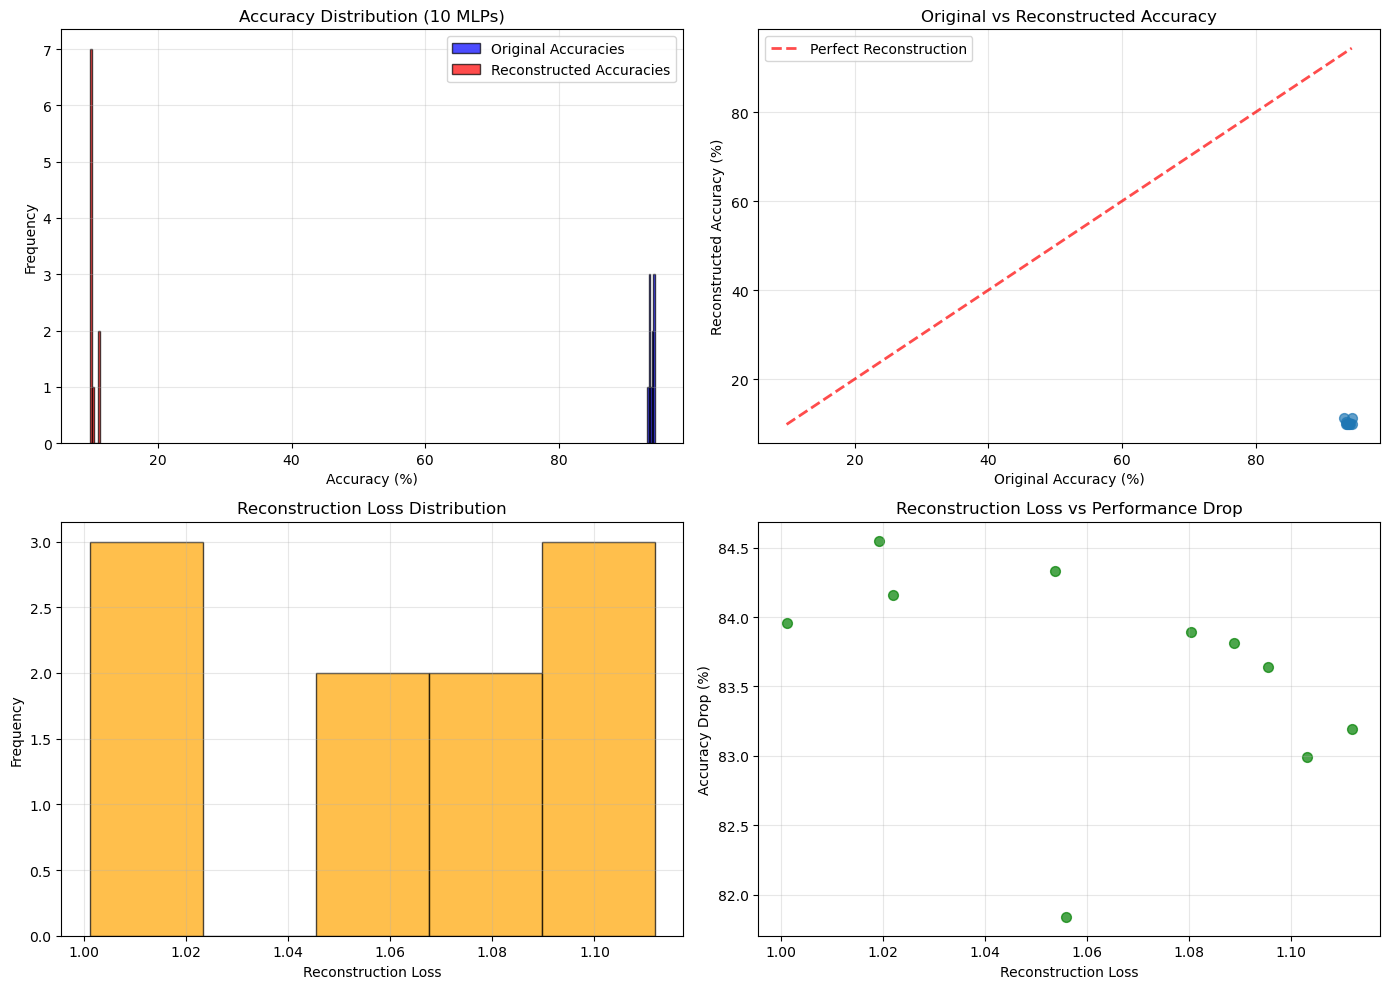

In [47]:
results = verify_reconstructions(trained_model, dataset, test_loader, build_mlp, test_mlp)